# <center> Download dos dados Geoespeciais das Linhas da SPTrans </center>

In [1]:
import os
import glob
import zipfile
import wget
import requests

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import folium

In [2]:
diretorio =  "C:/Users/f112596/Desktop/Projetos/DO/Lab Transp/" #"C:/Users/usuario/Pasta Raiz"
toke_api_olho_vivo = "720a62440aa64468688512a7812f84ad7d82f9f0145d8ab66186a1d6e58289ba"

In [3]:
class GTFS(object):    
    url_gtfs = 'https://www.sptrans.com.br/umbraco/Surface/PerfilDesenvolvedor/BaixarGTFS?memberName=sptrans'

    #Limpo o diretorio temporário de arquivos do tipo .ZIP e .TXT
    def Limpar_Diretorio(self):    
        arquivos_temp = glob.glob(diretorio + '/temp/*')
        for temp in arquivos_temp:
            os.remove(temp)
    
    
    #Download do GFTS zipado
    def Download_GTFS(self):
        wget.download(self.url_gtfs, out = diretorio + "/temp/")
    
    
    #Unzip dos arquivos do GFTS
    def Unzip_GTFS(self):
        for arquivo in os.listdir(diretorio+ "/temp/"):
                if arquivo.endswith(".zip"):
                    with zipfile.ZipFile(diretorio + '/temp/' + arquivo, 'r') as zip_ref:
                        zip_ref.extractall(diretorio + '/temp/')
                        break                        
                        
    def Carregar_Arquivos(self):
        lista_arquivos = []
        for arquivo in os.listdir(diretorio):
            if arquivo.endswith(".txt"): 
                lista_arquivos.append(arquivo)
        
        return lista_arquivos
    
    
    def Carregar_Linhas(self):
        try:    
            df_linhas = pd.read_csv(diretorio + '/temp/' + "/routes.txt", sep = ',')
            linhas = np.unique(df_linhas['route_id'].to_list())
            print(str(len(linhas)) + " linhas carregadas do GTFS")
            return linhas
        except:
            print("ERRO: Arquivo routes.txt não disponível no diretório: " + diretorio)
            linhas = None

In [4]:
class SPTransClient(object):
    session = requests.Session()
    
    #Parâmetros para a conexão
    url = 'http://api.olhovivo.sptrans.com.br/v2.1'
    token = toke_api_olho_vivo

    def auth(self):

        """
        Para autenticar-se no serviço de API do Olho Vivo
        é necessário efetuar uma chamada prévia utilizando
        o método http POST informando seu token de acesso.
        Essa chamada irá retornar true quando a autenticação
        for realizada com sucesso e false em caso de erros.
        """

        method = '/Login/Autenticar?token=' + self.token
        response = self.session.post(self.url + method)

        if response.cookies:
            return True

        return False
    
    
    
    def _get(self, path):
        """ HTTP GET comum para os demais métodos """
        response = self.session.get(self.url + path)
        data = response.json()
        return data


    def get_Detalhes_Linha(self, uid):
        return self._get('/Linha/CarregarDetalhes?codigoLinha=%s' % uid)
    
    
    def get_Linha(self, term):
        return self._get('/Linha/Buscar?termosBusca=%s' % term)
        
    
    def get_Paradas(self, parada):
        return self._get('/Parada/Buscar?termosBusca=%s' % parada)
    
    
    def get_Empresas(self):
        return self._get('/Empresa')

In [5]:
class Info_Data(object):        
    def recuperar_info_linhas(self, linhas, client):
        """
        Essa função recuperará as informações das linhas presentes no GTFS
        Preciso passar como argumentos:
            i) as linhas do GTFS; e
            ii) Client autenticado
        """
        
        dict_data_linhas = {}

        for linha in linhas:
            try:
                response = client.get_Linha(linha)
                for r in response:
                    dict_data_linhas[r['cl']] = r
            
            except BaseException as e:
                print('Erro na recuperação das Linhas: ' + str(e))
                
        return dict_data_linhas

In [6]:
class consolidador_Geoespacial(object):  
    """
    Fonte: https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx
    """

    #shp_Terminais = gpd.read_file(diretorio + /SIRGAS_SHP_terminal_onibus/sad6996_terminal_onibus.shp")
    shp_Pontos = gpd.read_file(diretorio + "/SIRGAS_SHP/SIRGAS_SHP_pontoonibus/SIRGAS_SHP_pontoonibus.shp")
    shp_Linhas = gpd.read_file(diretorio + "/SIRGAS_SHP/SIRGAS_SHP_linhaonibus/SIRGAS_SHP_linhaonibus_line.shp")
    shp_Distrito = gpd.read_file(diretorio + "/SIRGAS_SHP/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp")
    shp_SubPref = gpd.read_file(diretorio + "/SIRGAS_SHP/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura.shp")

            
    def linestring_to_points_tp(self, linestring):
        """
        Retorna o ponto geoespacial INICIAL 
        de uma linha geométrica
        """
        return Point(linestring.coords[0][0], linestring.coords[0][1])  
    

    def linestring_to_points_ts(self, linestring):
        """
        Retorna o ponto geoespacial FINAL 
        de uma linha geométrica
        """
        return Point(linestring.coords[len(linestring.coords)-1][0], linestring.coords[len(linestring.coords)-1][1])
    
    def point_to_lat_long(self, point):
        return str(point.x) + " , " + str(point.y)

    def info_GeoEspaciais(self, coluna):  
        shp_Linhas_ = None
        shp_Distrito_ = None
        shp_Linha_Distrito_ = None
        shp_Linha_Distrito_subPref_ = None
        
        #Crio o df geoespeacial das linhas e o formato
        shp_Linhas_ = self.shp_Linhas.copy()        
        shp_Linhas_[coluna] = shp_Linhas_.apply(lambda l: self.linestring_to_points_tp(l['geometry']) if coluna=='pt_inicial' else self.linestring_to_points_ts(l['geometry']), axis=1) #Defino a coluna de pt_inicial ou pt_final de acordo com o parâmetro passado
        shp_Linhas_ = shp_Linhas_.set_geometry(shp_Linhas_[coluna])
        shp_Linhas_.crs = "EPSG:31983"
        shp_Linhas_.to_crs(31983, inplace=True)
        shp_Linhas_['latitude_longitude'] = shp_Linhas_.apply(lambda p: self.point_to_lat_long(p[coluna]) , axis=1)
        
        #Faço um join com as informações do Ponto do ponto inicial ou final
        shp_Pontos_ = self.shp_Pontos.copy()
        shp_Pontos_.crs = "EPSG:31983"
        shp_Pontos_.to_crs(31983, inplace=True) 
        shp_Linha_Pontos_ = gpd.sjoin_nearest(shp_Linhas_, shp_Pontos_, how="left",)
        shp_Linha_Pontos_ = shp_Linha_Pontos_.set_geometry(shp_Linha_Pontos_['geometry'])
        shp_Linha_Pontos_.drop(columns=['index_right'], inplace=True)
        shp_Linha_Pontos_.crs = "EPSG:31983"
        shp_Linha_Pontos_.to_crs(31983, inplace=True)        

        
        #Faço um join com as informações do Distrito do ponto inicial ou final
        shp_Distrito_ = self.shp_Distrito.copy()
        shp_Linha_Pontos_Distrito_ = shp_Linha_Pontos_.sjoin(shp_Distrito_, how="left", predicate='intersects')
        shp_Linha_Pontos_Distrito_ = shp_Linha_Pontos_Distrito_.set_geometry(shp_Linha_Pontos_Distrito_['geometry'])
        shp_Linha_Pontos_Distrito_.drop(columns=['index_right'], inplace=True)
        shp_Linha_Pontos_Distrito_.crs = "EPSG:31983"
        shp_Linha_Pontos_Distrito_.to_crs(31983, inplace=True)   

        #Faço um join com as informações da Subprefeitura a partir do Distrito do ponto inicial ou final
        shp_SubPref_ = consolidador.shp_SubPref.copy()
        shp_Linha_Pontos_Distrito_subPref_ = shp_Linha_Pontos_Distrito_.sjoin(shp_SubPref_, how="left", predicate='intersects')

        
        #Colunas a serem retornadas
        colunas = ['ln_nome', 'ln_empresa', 'ln_codigo', coluna, 'pt_nome', 'pt_descric', 'pt_enderec', 'ds_codigo', 'ds_nome', 'ds_sigla', 'ds_subpref', 'sp_nome', 'latitude_longitude']
        shp_Linha_Pontos_Distrito_subPref_ = shp_Linha_Pontos_Distrito_subPref_[colunas] 

        #Remover duplicados
        shp_Linha_Pontos_Distrito_subPref_.drop_duplicates(subset=['ln_nome', 'ln_empresa', 'ln_codigo', 'ds_nome', 'ds_sigla', 'ds_subpref', 'sp_nome'], keep='first', inplace=True)
        
        
        if coluna == "pt_inicial":
            col_names = ['ln_nome_tp', 'ln_empresa_tp', 'ln_codigo_tp', 'pt_inicial_tp', 'pt_nome_tp', 'pt_descric_tp', 'pt_enderec_tp', 'ds_codigo_tp', 'ds_nome_tp', 'ds_sigla_tp', 'ds_subpref_tp', 'sp_nome_tp', 'latitude_longitude_tp']
        else:
            col_names = ['ln_nome_ts', 'ln_empresa_ts', 'ln_codigo_ts', 'pt_final_ts', 'pt_nome_ts', 'pt_descric_ts', 'pt_enderec_ts', 'ds_codigo_ts', 'ds_nome_ts', 'ds_sigla_ts', 'ds_subpref_ts', 'sp_nome_ts', 'latitude_longitude_ts']
        
        
        shp_Linha_Pontos_Distrito_subPref_ = shp_Linha_Pontos_Distrito_subPref_.set_axis(col_names, axis=1)
        
        return shp_Linha_Pontos_Distrito_subPref_
    
    
    
    def merge_dfs(self, df_tp_, df_ts_):        
        df_final = df_tp_.merge(df_ts_, left_on=['ds_codigo_tp', 'ln_codigo_tp'], right_on=['ds_codigo_ts', 'ln_codigo_ts'])
        df_final.drop(['pt_inicial_tp', 'pt_final_ts'], axis=1, inplace=True)
        df_final = df_final.applymap(str)
        
        return df_final
    
    
    def validacao_existencia_linhas(self, dict_data_linhas, shp_Linhas):
        """
        Realiza uma validação da existênci das linhas trazidas pela GTFS e 
        API Olho vivo no arquivo geoespacial
        """
        qtde_linhas = 0
        qtde_linhas_ok = 0

        for key, value in dict_data_linhas.items():
            qtde_linhas = qtde_linhas + 1
            try:        
                if len(shp_Linhas[shp_Linhas['ln_codigo'].str.upper().str.contains(dict_data_linhas[key]['lt'])]):
                    dict_data_linhas[key]['verificacao_lt'] = "OK"
                    qtde_linhas_ok = qtde_linhas_ok + 1
                else:
                    dict_data_linhas[key]['verificacao_lt'] = "NOK"
            except:
                dict_data_linhas[key]['verificacao_lt'] = "NOK"    

        print("Considerando um total de " + str(len(dict_data_linhas.keys()))+ " linhas recuperadas, " + str(round((qtde_linhas_ok/qtde_linhas * 100), 2)) + "% foram corretamente verificadas com base nos dados do GeoSampa!")

        return dict_data_linhas

DriverError: C:\Users\f112596\Desktop\Projetos\DO\Lab Transp/SIRGAS_SHP/SIRGAS_SHP_pontoonibus/SIRGAS_SHP_pontoonibus.shp: No such file or directory

In [ ]:
#Instaciação das Classes
Ini_GFTS = GTFS() #Responsável pelo download, extração e manuseio do GTFS
SPTransClient_1 = SPTransClient() #Reponsável pela captura de informações e das linhas
Info_Data_1 = Info_Data() #Responsável por montar uma dicionário com as linhas, usando o client da API Olho Vivo
consolidador = consolidador_Geoespacial() #Responsável por montar o arquivo final com base nos arquivos .shp

In [10]:
#Realiza o Download dos Arquivos GTFS
Carregar_Arquivos = 1

if Carregar_Arquivos == 1:
    '''
    Se a variável Carregar_Arquivos for igual a 1, 
    todo GTFS será baixado e extraído novamente para o diretório 'diretorio/temp/'
    '''
    Ini_GFTS.Limpar_Diretorio()
    Ini_GFTS.Download_GTFS()
    Ini_GFTS.Unzip_GTFS()

linhas = Ini_GFTS.Carregar_Linhas()

1330 linhas carregadas do GTFS


In [11]:
#Recuperar os dados das linhas
if SPTransClient_1.auth():
    print("Conexão Realizada com Sucesso!!!")
else:
    print("Erro de autenticação na Api Olho Vivo. Verifique os parâmetros e tente novamente")
    
#Monta o dicionário com os detalhes das linhas
dict_data_linhas = Info_Data_1.recuperar_info_linhas(linhas, SPTransClient_1)

#Verifica o percentual de ocorrência de linhas no dicionário, com aquelas nos arquivos .shp
dict_data_linhas = consolidador.validacao_existencia_linhas(dict_data_linhas, consolidador.shp_Linhas)

Conexão Realizada com Sucesso!!!
Erro na recuperação das Linhas: ('Connection aborted.', ConnectionResetError(10054, 'Foi forçado o cancelamento de uma conexão existente pelo host remoto', None, 10054, None))
Considerando um total de 2634 linhas recuperadas, 99.47% foram corretamente verificadas com base nos dados do GeoSampa!


In [12]:
df_tp_ = consolidador.info_GeoEspaciais("pt_inicial")
df_ts_ = consolidador.info_GeoEspaciais("pt_final")

df_final = consolidador.merge_dfs(df_tp_, df_ts_)

df_final['ln_codigo_tp'] = df_final['ln_codigo_tp'].astype(str)
df_final['ln_codigo_tp'] = df_final['ln_codigo_tp'].str.replace("-", "")
df_final['ln_codigo_ts'] = df_final['ln_codigo_ts'].astype(str)
df_final['ln_codigo_ts'] = df_final['ln_codigo_ts'].str.replace("-", "")

df_final.to_csv(diretorio + "BD_Linhas_Geoespacial.csv", sep=';', encoding="cp1252", index=False)

In [13]:
df_final.to_csv("BD_Linhas_Geoespacial.csv", sep=';', index=False, encoding="cp1252")

In [14]:
df_final

,ln_nome_tp,ln_empresa_tp,ln_codigo_tp,pt_nome_tp,pt_descric_tp,pt_enderec_tp,ds_codigo_tp,ds_nome_tp,ds_sigla_tp,ds_subpref_tp,...,ln_codigo_ts,pt_nome_ts,pt_descric_ts,pt_enderec_ts,ds_codigo_ts,ds_nome_ts,ds_sigla_ts,ds_subpref_ts,sp_nome_ts,latitude_longitude_ts
0,TERM. JD. BRITANIA - JD. MONT,NORTE BUSS S.A.,101210,"TERM. JARDIM BRITÂNIA , 0",Av. Pierre Renoir,Av. Pierre Renoir,3,ANHANGUERA,ANH,PERUS,...,101210,"R. PEDRA DE BENDENGO , 1",Rua Lagoa do Morro,ua Lagoa do Morro,3,ANHANGUERA,ANH,PERUS,PERUS,"316168.16837100557 , 7406140.048366022"
1,JD. PERY ALTO - TERM. AMARAL,SAMBAIBA,118C10,"R. DARIO VILARES BARBOSA , 170",VEL DEZESSETE/ R ALFARROBEIRAS,VEL DEZESSETE/ R ALFARROBEIRAS,13,CACHOEIRINHA,CAC,CASA VERDE-CACHOEIRINHA,...,118C10,"R. DARIO VILARES BARBOSA , 170",VEL DEZESSETE/ R ALFARROBEIRAS,VEL DEZESSETE/ R ALFARROBEIRAS,13,CACHOEIRINHA,CAC,CASA VERDE-CACHOEIRINHA,CASA VERDE-CACHOEIRINHA,"329262.3146598662 , 7404777.693484828"
2,JD. PERY ALTO - TERM. AMARAL,SAMBAIBA,118C10,"TERM. AMARAL GURGEL , 0",nan,nan,69,SANTA CECILIA,SCE,SE,...,118C10,"TERM. AMARAL GURGEL , 0",nan,nan,69,SANTA CECILIA,SCE,SE,SE,"331744.3250251508 , 7395795.584006355"
3,LAUZANE PAULISTA - LAPA,NORTE BUSS S.A.,118Y10,"R. MANOEL ANTÔNIO TORRES , 0",AV DIREITOS HUMANOS/ R JUDITH ZUMKELLER,AV DIREITOS HUMANOS/ R JUDITH ZUMKELLER,51,MANDAQUI,MAN,SANTANA-TUCURUVI,...,118Y10,"R. MANOEL ANTÔNIO TORRES , 0",AV DIREITOS HUMANOS/ R JUDITH ZUMKELLER,AV DIREITOS HUMANOS/ R JUDITH ZUMKELLER,51,MANDAQUI,MAN,SANTANA-TUCURUVI,SANTANA-TUCURUVI,"333048.1692290637 , 7403297.355515486"
4,LAUZANE PAULISTA - LAPA,NORTE BUSS S.A.,118Y10,"R. DR. CINCINATO POMPONET , 91",ENTRE AS RUAS HERBART E MARTIM TENÓRIO,ENTRE AS RUAS HERBART E MARTIM TENÓRIO,48,LAPA,LAP,LAPA,...,118Y10,"R. DR. CINCINATO POMPONET , 91",ENTRE AS RUAS HERBART E MARTIM TENÓRIO,ENTRE AS RUAS HERBART E MARTIM TENÓRIO,48,LAPA,LAP,LAPA,LAPA,"326184.6838655257 , 7397925.6019029375"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,METRÔ BUTANTÃ - METRÔ VL. MAR,GATO PRETO,N83911,"TERM. METRÔ BUTANTÃ , 0",nan,nan,12,BUTANTA,BUT,BUTANTA,...,N83911,"TERM. METRÔ BUTANTÃ , 0",nan,nan,12,BUTANTA,BUT,BUTANTA,BUTANTA,"325552.501968986 , 7392150.977720287"
2101,TERM. VL. MARIANA - STA. CECÍ,TRANSPPASS,N84011,"TERM. METRÔ VILA MARIANA , 0",AV PROFESSOR NOE AZEVEDO/ R VERGUEIRO,AV PROFESSOR NOE AZEVEDO/ R VERGUEIRO,90,VILA MARIANA,VMN,VILA MARIANA,...,N84011,"TERM. METRÔ VILA MARIANA , 0",AV PROFESSOR NOE AZEVEDO/ R VERGUEIRO,AV PROFESSOR NOE AZEVEDO/ R VERGUEIRO,90,VILA MARIANA,VMN,VILA MARIANA,VILA MARIANA,"333296.2862316376 , 7390273.256773037"
2102,TERM. VL. MARIANA - STA. CECÍ,TRANSPPASS,N84111,"TERM. METRÔ VILA MARIANA , 0",R CORNELIO DE PAULA JUNIOR/ AV PROFESSOR NOE A...,CORNELIO DE PAULA JUNIOR/ AV PROFESSOR NOE AZE...,90,VILA MARIANA,VMN,VILA MARIANA,...,N84111,"TERM. METRÔ VILA MARIANA , 0",R CORNELIO DE PAULA JUNIOR/ AV PROFESSOR NOE A...,CORNELIO DE PAULA JUNIOR/ AV PROFESSOR NOE AZE...,90,VILA MARIANA,VMN,VILA MARIANA,VILA MARIANA,"333232.3606558227 , 7390266.767836802"
2103,TERM. PINHEIROS - COHAB RAPOS,TRANSPPASS,N84211,"TERM. PINHEIROS - PL 5 , 0",nan,nan,62,PINHEIROS,PIN,PINHEIROS,...,N84211,"TERM. PINHEIROS - PL 5 , 0",nan,nan,62,PINHEIROS,PIN,PINHEIROS,PINHEIROS,"326308.089100469 , 7392768.251827043"


In [16]:
#Crio uma cópia dos arquivos .SHP
df_linhas = consolidador.shp_Linhas.copy()
df_linhas = df_linhas.set_geometry(df_linhas['geometry'])
df_linhas.crs = "EPSG:31983"
df_linhas.to_crs(31983, inplace=True)


df_distritos = consolidador.shp_Distrito.copy()
df_distritos = df_distritos.set_geometry(df_distritos['geometry'])
df_distritos.crs = "EPSG:31983"
df_distritos.to_crs(31983, inplace=True)

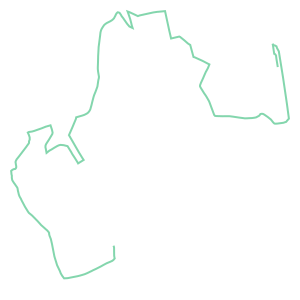

In [17]:

codigo_linha = '1012-10' #String (entre parênteses)
df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry']

In [ ]:
df_linhas[df_linhas['ln_codigo'] == codigo_linha]

In [ ]:
["Distrito 1", "Distrito 2", "Distrito 3", "Distrito 4",]

print("A Linha Pesquisada 1012-10 passa pelos seguintes Distritos: \n")
for d in ["Distrito 1", "Distrito 2", "Distrito 3", "Distrito 4",]:
    print(d)

In [ ]:
df_linha_selecionada = df_linhas[df_linhas['ln_codigo'] == codigo_linha]
df_linha_selecionada

In [ ]:
df_linha_selecionada = df_linhas[df_linhas['ln_codigo'] == codigo_linha]
df_linha_selecionada.crs = "EPSG:31983"
df_linha_selecionada.to_crs(31983, inplace=True)
df_linha_selecionada

In [ ]:
for p in range(df_linha_selecionada.iloc[0]['geometry']:
    print(p)

In [ ]:
len(df_linha_selecionada.iloc[0]['geometry'])

In [ ]:


Point(linestring.coords[0][0], linestring.coords[0][1])  

In [ ]:
df_linha_selecionada.iloc[0]['geometry']

In [ ]:
df_distritos[df_distritos['geometry'] in (df_linha_selecionada.iloc[0]['geometry'])]

In [ ]:
df_Distritos_Linha = df_distritos.overlay(df_linha_selecionada, how='intersection')
df_Distritos_Linha

In [ ]:
df_Linha_Distritos_ = gpd.sjoin_nearest(df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)], df_distritos, how="left",)
df_Linha_Distritos_

In [ ]:
df_final[df_final['ln_codigo_tp']==codigo_linha].columns

In [ ]:
#Referenciamento da linha
df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry']
ponto_partida = consolidador.linestring_to_points_tp(df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry'])


mapa = folium.Map([tp.x, tp.y], zoom_start=1)# crs='31983')

#Sobreposição da Linha
folium.Choropleth(    
    df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry'],    
    line_weight=3,
    line_color='blue'
).add_to(mapa)

#Sobreposição dos Distritos
folium.Choropleth(    
    df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry'],    
    line_weight=3,
    line_color='blue'
).add_to(mapa)

mapa

In [ ]:

print(tp)

In [ ]:
df_distritos.iloc[0]['geometry'].exterior.coords[0][0]

In [ ]:
df_linhas

In [ ]:
tp.x

In [ ]:
df_linhas.iloc[np.min(df_linhas[df_linhas['ln_codigo'] == codigo_linha].index)]['geometry']

In [ ]:
df_distritos.iloc[0]['geometry']